In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maindatasetfinal2/train_task2.csv
/kaggle/input/task2bert/task2_test.csv
/kaggle/input/task2bert/task2_train.csv


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, TFDistilBertModel
from transformers import AlbertTokenizer, TFAlbertModel

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from imblearn.over_sampling import SMOTE
from imblearn.combine import *
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import keras
import os
import re 

In [18]:
def preprocess(text):
  
  text=text.lower()
  text=re.sub(r'rt\s*@[^:]*:\s', ' ', text)
  text=re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text=re.sub(r' t .*$', '', text)
  text=re.sub(r'\b[a-zA-Z]\b', '', text)
  text=re.sub(r'/^\s+|\s+$|\s+(?=\s)/g', '', text);
  text = re.sub(r's+[a-zA-Z]s+', '', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text=re.sub(r'https?','',text)
  text=re.sub(r'#[A-Za-z0-9_]+','',text)
  text=re.sub(r'\.\.\.',' ',text)
  text=text.replace('…',' ')
  text=text.replace('..',' ')
  text=re.sub(r'@\w*',r'',text)
  text=re.sub(r'\s{2,}',r' ',text)
  text=re.sub(r'$[\s]+','',text)
  text=text.replace('&amp','')
  text=text.replace('&gt','')
  text=text.replace('&lt','')
  text=re.sub(r'([\w\d]+)([^\w\d ]+)', r'\1 \2',text)
  text=re.sub(r'([^\w\d ]+)([\w\d]+)', r'\1 \2',text)
 
  return text

In [19]:
train = pd.read_csv('../input/maindatasetfinal2/train_task2.csv')
train

,tweet_text,text_human_class,type
0,no an undocumented immigrant did not start the...,non_informative,1
1,the massage therapi reaching out to those caug...,humanitarian,0
2,morning meeting we continue to tackle the dam...,structure,2
3,still waiting for my power to come back after ...,non_informative,1
4,floridians with solarpanels were able to get e...,non_informative,1
...,...,...,...
27522,last tripadvisor review restaurant in amatrice...,structure,2
27523,drone shows damage around amatrice as rescue ...,structure,2
27524,convent among collapsed buildings in amatrice...,structure,2
27525,the sun ri over collapsed buildings following...,structure,2


In [20]:
test = pd.read_csv('../input/task2bert/task2_test.csv', index_col = 0)
del(test["tweet_id"])
del(test["image_id"])
del(test["image_path"])
del(test["text_info_conf"])
del(test["image_info"])
del(test["image_info_conf"])
del(test["text_human"])
del(test["text_human_conf"])
del(test["image_human"])
del(test["image_human_conf"])
del(test["image_damage"])
del(test["image_damage_conf"])
del(test["image_url"])
del(test["Unnamed: 0.1"])
del(test["image_human_class"])
del(test["text_info"])

test["tweet_text"]=test["tweet_text"].apply(lambda x: preprocess(x))
test["type"] = test["text_human_class"].apply(lambda x: 0 if x == "humanitarian" else 1 if x == "non_informative" else 2)

test

,tweet_text,text_human_class,type
11755,selling popcorn at lunch to benefit victims of...,humanitarian,0
1157,not only california northern spain amp portuga...,non_informative,1
16557,5pm tuesday tropical update maria still catego...,non_informative,1
7679,3 scenes of landsat ingested to hdds for event...,non_informative,1
196,realomarnavarro schnauzermom777 can you stop ...,non_informative,1
...,...,...,...
2888,my town in pr after hurricane maria,non_informative,1
8619,stiletto in texas it more than shoe it an att...,non_informative,1
16509,help our members affected by harvey and irma d...,humanitarian,0
1418,california wine country wildfires near contain...,non_informative,1


In [21]:
train["type"].value_counts()

0    9549
1    9305
2    8673
Name: type, dtype: int64

In [22]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
albert = TFAlbertModel.from_pretrained('albert-base-v2', output_hidden_states = True)

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [23]:
tokenized_train = train["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=60)))
tokenized_test = test["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=60)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
max_len = 0

for i in tokenized_train.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

60

In [25]:
input_ids_train= np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
attention_mask_train= np.where(input_ids_train!= 0, 1, 0)

input_ids_test= np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
attention_mask_test=np.where(input_ids_test!= 0, 1, 0)

In [26]:
arr_train = train["type"].values
arr_test = test["type"].values

num_samples_train = len(train)
num_samples_test = len(test)

labels_train = np.zeros((num_samples_train, arr_train.max()+1))
labels_test = np.zeros((num_samples_test, arr_test.max()+1))

labels_train[np.arange(num_samples_train), arr_train] = 1
labels_test[np.arange(num_samples_test), arr_test] = 1

In [27]:
dataset_train = tf.data.Dataset.from_tensor_slices((input_ids_train,attention_mask_train,labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((input_ids_test,attention_mask_test,labels_test))

def map_func(input_ids, masks, labels):
    return {'input_ids' : input_ids, 'attention_mask' : masks}, labels

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [28]:
dataset_train = dataset_train.shuffle(4800)

dataset_train = dataset_train.batch(128)
dataset_test = dataset_test.batch(8)

In [30]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = "input_ids", dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,), name = "attention_mask", dtype = 'int32')

embeddings = albert(input_ids, attention_mask=mask)
last_layer = embeddings[0]

#cls_token = hidden_layers[:, 0, :]
#conc_layer1 = hidden_layers[-4]
#conc_layer2 = hidden_layers[-3]
#conc_layer3 = hidden_layers[-2]
#conc_layer4 = hidden_layers[-1]
#conc = tf.keras.layers.Concatenate()([conc_layer1, conc_layer2, conc_layer3, conc_layer4])

cod = tf.keras.layers.LSTM(128, return_sequences = True)(last_layer)
cod = tf.keras.layers.Dropout(0.2)(cod)
cod = tf.keras.layers.LSTM(128)(cod)
cod = tf.keras.layers.Dropout(0.2)(cod)
cod = tf.keras.layers.Dense(64)(cod)

y = tf.keras.layers.Dense(3, activation="softmax", name="outputs")(cod)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = [y])

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = keras.callbacks.ModelCheckpoint('/kaggle/working/best_model_Albert_task2-lastlayergooddecay.h5', monitor='val_loss', mode='min', verbose = 1, save_best_only=True)

#class_weights = {1: 0.1288,
#                0: 0.3084,
#                2: 1.0072}

model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

In [34]:
history = model.fit(
    dataset_train,
    validation_data = dataset_test,
    epochs = 200,
    callbacks=[es,mc]
)

Epoch 1/200


2022-05-17 20:09:31.222495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-17 20:09:36.475005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


216/216 [==============================] - 217s 921ms/step - loss: 0.4717 - accuracy: 0.8324 - precison: 0.8608 - recall: 0.7872 - val_loss: 0.8195 - val_accuracy: 0.7000 - val_precison: 0.7156 - val_recall: 0.6666

Epoch 00001: val_loss improved from inf to 0.81950, saving model to /kaggle/working/best_model_Albert_task2-lastlayergooddecay.h5
Epoch 2/200
216/216 [==============================] - 196s 907ms/step - loss: 0.3343 - accuracy: 0.8861 - precison: 0.8947 - recall: 0.8780 - val_loss: 0.8030 - val_accuracy: 0.7125 - val_precison: 0.7236 - val_recall: 0.6942

Epoch 00002: val_loss improved from 0.81950 to 0.80302, saving model to /kaggle/working/best_model_Albert_task2-lastlayergooddecay.h5
Epoch 3/200
216/216 [==============================] - 196s 908ms/step - loss: 0.3187 - accuracy: 0.8904 - precison: 0.8958 - recall: 0.8834 - val_loss: 0.7014 - val_accuracy: 0.7548 - val_precison: 0.7629 - val_recall: 0.7365

Epoch 00003: val_loss improved from 0.80302 to 0.70137, saving m

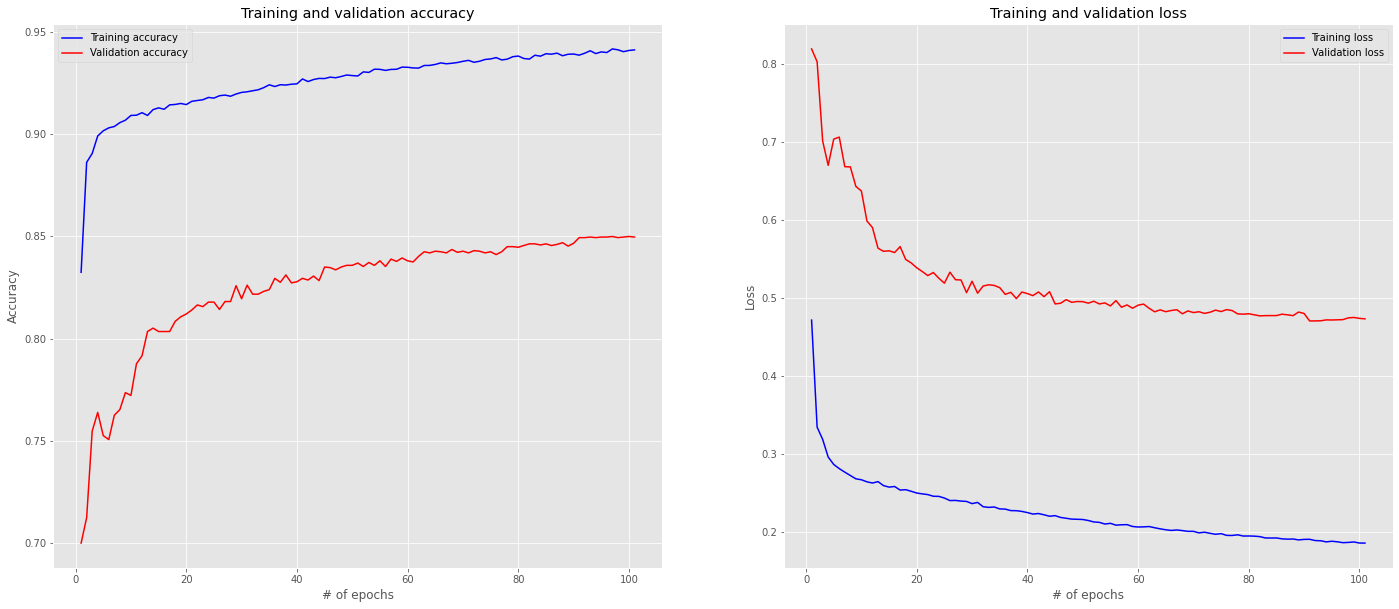

In [35]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('# of epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history)

In [ ]:
from keras.models import load_model

saved_model = tf.keras.models.load_model('./best_model_Albert_task2-lastlayergooddecay.h5', custom_objects={"TFAlbertModel": TFAlbertModel})

In [37]:
y_pred = [] 
y_true = [] 

for inputs_id_mask_batch, class_batch in dataset_test:   
   y_true.append(np.argmax(class_batch, axis = -1))
   preds = saved_model.predict(inputs_id_mask_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

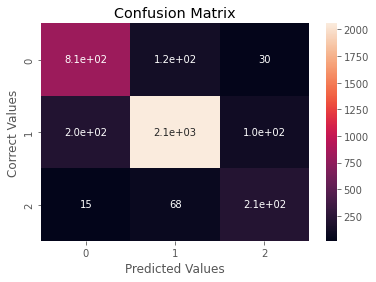


              precision    recall  f1-score   support

           0       0.79      0.84      0.81       958
           1       0.92      0.87      0.89      2367
           2       0.61      0.72      0.66       292

    accuracy                           0.85      3617
   macro avg       0.77      0.81      0.79      3617
weighted avg       0.86      0.85      0.85      3617



In [38]:
cm = confusion_matrix(correct_labels, predicted_labels)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()
print()
print(classification_report(correct_labels, predicted_labels))